# 1. Import Packages

In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import time
import re
import os   
import seaborn as sns

from io import StringIO
from sklearn import tree
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.feature_selection import SelectKBest

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from xgboost import XGBClassifier

from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from IPython.display import Image
from IPython.display import display, HTML

plt.style.use('seaborn-paper')
plt.rcParams['figure.figsize'] = [12, 8] ## plot size
plt.rcParams['axes.linewidth'] = 2.0 #set the value globally

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## settings for formatting of the notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style> .output_png { display: table-cell; text-align: center; vertical-align: middle; } </style>"))
display(HTML("<style>.MathJax {font-size: 300%;}</style>"))

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 2. Input Command Line Arguments

In [3]:
PLOT_FONT_SIZE = 15    #font size for axis of plots
RANDOM_STATE = 42     #random state used for splitting data and training models. Need this value to be fixed for same splits and models across experiments
BAR_CHART_BAR_WIDTH = 0.25

## input file
INPUT_PSYCHOMETRIC_DIMENSION = "DrugExp"
LABEL_VAL = "Severity"

## lists for ROC curves
rocCurveData = []

# 3. Load data

In [4]:
## input data files
dataFileText = INPUT_PSYCHOMETRIC_DIMENSION + "_Text" +".tsv"
dataFileStructured = INPUT_PSYCHOMETRIC_DIMENSION + "_Structured" +".tsv"
delimiter = "\t"

## training, testing, and validation data
inputDataTrain = pd.DataFrame(pd.read_csv("DrugExp/training_data/train_" + dataFileText, delimiter))
inputDataTest = pd.DataFrame(pd.read_csv("DrugExp/test_data/test_" + dataFileText, delimiter))
inputDataValidation = pd.DataFrame(pd.read_csv("DrugExp/validation_data/validation_" + dataFileText, delimiter))

## demographics data
inputDataTrainStructured = pd.DataFrame(pd.read_csv("DrugExp/training_data/train_" + dataFileStructured, delimiter))
inputDataTestStructured = pd.DataFrame(pd.read_csv("DrugExp/test_data/test_" + dataFileStructured, delimiter))
inputDataValidationStructured = pd.DataFrame(pd.read_csv("DrugExp/validation_data/validation_" + dataFileStructured, delimiter))

In [5]:
inputDataTrain.head()

,Label,Text
0,-1,Schizophrenia Only been on it one day. I took ...
1,-1,Cancer drug arimidex gave me osteoporosis Took...
2,-1,Osteoporosis Dysphagia (inability to swallow)....
3,-1,Ostoclerosis Took it at 630 am by 230pm receiv...
4,-1,Osteopenia My limbs feel like I have weights t...


Combine test, train, validation and create flag for test

In [6]:
inputDataTrain['is_test_set'] = 0.0
inputDataValidation['is_test_set'] = 0.0
inputDataTest['is_test_set'] = 1.0

inputDataTrain['is_valid_set'] = 0.0
inputDataValidation['is_valid_set'] = 1.0
inputDataTest['is_valid_set'] = 0.0

combinedDataUnstructured = inputDataTrain.append(inputDataValidation)
combinedDataUnstructured = combinedDataUnstructured.append(inputDataTest)

In [7]:
inputDataTrainStructured['is_test_set'] = 0.0
inputDataValidationStructured['is_test_set'] = 0.0
inputDataTestStructured['is_test_set'] = 1.0

inputDataTrainStructured['is_valid_set'] = 0.0
inputDataValidationStructured['is_valid_set'] = 1.0
inputDataTestStructured['is_valid_set'] = 0.0

combinedDataStructured = inputDataTrainStructured.append(inputDataValidationStructured)
combinedDataStructured = combinedDataStructured.append(inputDataTestStructured)

# 4. Engineer features

In [8]:
combinedDataUnstructured = combinedDataUnstructured.reset_index(drop=False)  # First reset the index of the data frames.
combinedDataStructured = combinedDataStructured.reset_index(drop=False)  # First reset the index of the data frames.

Lemmatize data

In [9]:
wordnet_lemmatizer = WordNetLemmatizer()
stopset = list(set(stopwords.words('english')))
cleaned_texts = []
for text in combinedDataUnstructured['Text']:  # Loop through the tokens (the words or symbols) in each tweet.   
    cleaned_text = text.lower()  # Convert the text to lower case
    cleaned_text = ' '.join([word for word in cleaned_text.split() if word not in stopset])  # Keep only words that are not stopwords.
    cleaned_text = ' '.join([wordnet_lemmatizer.lemmatize(word, pos='n') for word in cleaned_text.split()])  # Keep each noun's lemma.
    cleaned_text = ' '.join([wordnet_lemmatizer.lemmatize(word, pos='v') for word in cleaned_text.split()])  # Keep each verb's lemma.
    cleaned_text = re.sub("[^a-zA-Z]"," ", cleaned_text)  # Remove numbers and punctuation.
    cleaned_text = ' '.join(cleaned_text.split())  # Remove white space.
    cleaned_texts.append(cleaned_text)

combinedDataUnstructured['cleanText'] = cleaned_texts

Load happiness dictionary

In [10]:
import json
import urllib.request
url='http://hedonometer.org/api/v1/words/?format=json'
data = urllib.request.urlopen(url).read().decode('utf-8')
loaded_json = json.loads(data)
happ_dict = loaded_json['objects']
from pandas.io.json import json_normalize
happ_df = json_normalize(happ_dict)

Add happiness score

In [11]:
word_happs_df = happ_df[['word', 'happs']]

In [12]:
%%time
happs_list = []
for i in range(0, len(combinedDataUnstructured)):
    text = combinedDataUnstructured.loc[i]['cleanText']
    text_df = pd.DataFrame(pd.Series(text.split()), columns=['word'])
    text_happs_df = pd.merge(text_df, word_happs_df, on='word')
    happs_list.append(text_happs_df['happs'].sum())
combinedDataUnstructured['happ_score'] = happs_list

CPU times: user 49.6 s, sys: 4.9 ms, total: 49.6 s
Wall time: 49.6 s


Load Harvard dictionaries

In [13]:
genInq_df = pd.read_csv('inquirerbasic.csv', encoding='latin-1', low_memory=False)
genInq_df['Entry'] = [word.lower() for word in genInq_df['Entry']]

Look at top words for positive and negatives

In [14]:
df_neg = combinedDataUnstructured[combinedDataUnstructured['Label'] == -1]
df_pos = combinedDataUnstructured[combinedDataUnstructured['Label'] == 1]

corpus = list(df_pos['cleanText'])
corpus_vectorizer = CountVectorizer(ngram_range=(1, 1), max_features=30)
bag_of_words_pos = corpus_vectorizer.fit_transform(corpus)
bag_of_words_pos_df = pd.DataFrame(bag_of_words_pos.toarray(), columns=corpus_vectorizer.get_feature_names())

corpus = list(df_neg['cleanText'])
corpus_vectorizer = CountVectorizer(ngram_range=(1, 1), max_features=30)
bag_of_words_neg = corpus_vectorizer.fit_transform(corpus)
bag_of_words_neg_df = pd.DataFrame(bag_of_words_neg.toarray(), columns=corpus_vectorizer.get_feature_names())

freq_words_pos = pd.DataFrame(bag_of_words_pos_df.mean(axis=0), 
                                     index=bag_of_words_pos_df.columns, columns=['Avg count (low severity)'])
freq_words_neg = pd.DataFrame(bag_of_words_neg_df.mean(axis=0), 
                                     index=bag_of_words_neg_df.columns, columns=['Avg count (high severity)'])

freq_words_pos.join(freq_words_neg, how='outer')

,Avg count (low severity),Avg count (high severity)
also,0.205851,NaN
anxiety,0.207825,0.253988
back,0.233848,0.290160
day,0.722362,0.704154
depression,NaN,0.254462
doctor,NaN,0.281156
drug,0.363963,0.476228
effect,0.494436,0.408308
feel,0.382627,0.474807
first,0.273690,NaN


In [15]:
df_neg = combinedDataUnstructured[combinedDataUnstructured['Label'] == -1]
df_pos = combinedDataUnstructured[combinedDataUnstructured['Label'] == 1]

corpus = list(df_pos['cleanText'])
corpus_vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=30)
bag_of_words_pos = corpus_vectorizer.fit_transform(corpus)
bag_of_words_pos_df = pd.DataFrame(bag_of_words_pos.toarray(), columns=corpus_vectorizer.get_feature_names())

corpus = list(df_neg['cleanText'])
corpus_vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=30)
bag_of_words_neg = corpus_vectorizer.fit_transform(corpus)
bag_of_words_neg_df = pd.DataFrame(bag_of_words_neg.toarray(), columns=corpus_vectorizer.get_feature_names())

freq_words_pos = pd.DataFrame(bag_of_words_pos_df.mean(axis=0), 
                                     index=bag_of_words_pos_df.columns, columns=['Avg count (low severity)'])
freq_words_neg = pd.DataFrame(bag_of_words_neg_df.mean(axis=0), 
                                     index=bag_of_words_neg_df.columns, columns=['Avg count (high severity)'])

freq_words_pos.join(freq_words_neg, how='outer')

,Avg count (low severity),Avg count (high severity)
back pain,0.032843,0.059074
birth control,0.066583,0.147054
blood pressure,0.029971,0.046596
day take,0.038227,0.033486
depression anxiety,NaN,0.030643
dry mouth,0.094401,0.033486
every day,0.027818,NaN
feel like,0.058507,0.102353
felt like,NaN,0.068394
first day,0.027279,NaN


In [16]:
Feel_dummy_df = pd.get_dummies(genInq_df[['Entry','Feel']], prefix=['contains'], columns=['Feel'])
Feel_dummy_df.head()

Feel_list = []
for i in range(0, len(combinedDataUnstructured)):
    text = combinedDataUnstructured.loc[i]['cleanText']
    text_df = pd.DataFrame(pd.Series(text.split()), columns=['Entry'])
    text_Feel_df = pd.merge(text_df, Feel_dummy_df, on='Entry')
    Feel_list.append(text_Feel_df['contains_Feel'].sum())
combinedDataUnstructured['Feel_score'] = Feel_list

In [17]:
combinedDataUnstructured['Feel_score'].value_counts(dropna=False)

0    11594
1      272
2       30
3        5
4        2
Name: Feel_score, dtype: int64

In [18]:
Negativ_dummy_df = pd.get_dummies(genInq_df[['Entry','Negativ']], prefix=['contains'], columns=['Negativ'])
Negativ_dummy_df.head()

Negativ_list = []
for i in range(0, len(combinedDataUnstructured)):
    text = combinedDataUnstructured.loc[i]['cleanText']
    text_df = pd.DataFrame(pd.Series(text.split()), columns=['Entry'])
    text_Negativ_df = pd.merge(text_df, Negativ_dummy_df, on='Entry')
    Negativ_list.append(text_Negativ_df['contains_Negativ'].sum())
combinedDataUnstructured['Negativ_score'] = Negativ_list

In [19]:
combinedDataUnstructured['Negativ_score'].value_counts(dropna=False)

2     1739
3     1644
1     1594
4     1389
5     1137
0     1040
6      855
7      671
8      533
9      349
10     252
11     197
12     144
13      88
14      65
16      50
15      50
17      28
18      19
19      13
20      12
21       9
23       7
22       5
26       4
27       4
24       3
61       1
30       1
Name: Negativ_score, dtype: int64

In [20]:
Positiv_dummy_df = pd.get_dummies(genInq_df[['Entry','Positiv']], prefix=['contains'], columns=['Positiv'])
Positiv_dummy_df.head()

Positiv_list = []
for i in range(0, len(combinedDataUnstructured)):
    text = combinedDataUnstructured.loc[i]['cleanText']
    text_df = pd.DataFrame(pd.Series(text.split()), columns=['Entry'])
    text_Positiv_df = pd.merge(text_df, Positiv_dummy_df, on='Entry')
    Positiv_list.append(text_Positiv_df['contains_Positiv'].sum())
combinedDataUnstructured['Positiv_score'] = Positiv_list

In [21]:
combinedDataUnstructured['Positiv_score'].value_counts(dropna=False)

0     5863
1     3112
2     1520
3      702
4      345
5      186
6       82
7       43
8       30
10       7
9        7
11       3
15       2
13       1
Name: Positiv_score, dtype: int64

In [22]:
Pain_dummy_df = pd.get_dummies(genInq_df[['Entry','Pain']], prefix=['contains'], columns=['Pain'])
Pain_dummy_df.head()

Pain_list = []
for i in range(0, len(combinedDataUnstructured)):
    text = combinedDataUnstructured.loc[i]['cleanText']
    text_df = pd.DataFrame(pd.Series(text.split()), columns=['Entry'])
    text_Pain_df = pd.merge(text_df, Pain_dummy_df, on='Entry')
    Pain_list.append(text_Pain_df['contains_Pain'].sum())
combinedDataUnstructured['Pain_score'] = Pain_list

In [23]:
combinedDataUnstructured['Pain_score'].value_counts(dropna=False)

0     4566
1     3045
2     2003
3     1121
4      542
5      304
6      154
7       75
8       37
9       25
10      13
11       9
13       3
12       3
14       2
15       1
Name: Pain_score, dtype: int64

Create matrix of bag of words

In [24]:
corpus = list(combinedDataUnstructured['cleanText'])
corpus_vectorizer = CountVectorizer(ngram_range=(1,2), max_features=500)
bag_of_words = corpus_vectorizer.fit_transform(corpus)
bag_of_words_df = pd.DataFrame(bag_of_words.toarray(), columns=corpus_vectorizer.get_feature_names())
combinedDataUnstructured = combinedDataUnstructured.join(bag_of_words_df, lsuffix='', rsuffix='_1')

Combine with the other data

In [25]:
combinedData = pd.merge(combinedDataUnstructured, combinedDataStructured, left_on=['index','is_valid_set','is_test_set'], right_on = ['index','is_valid_set','is_test_set'], how='left')

Create dummies for drugs

In [26]:
combinedData['Drug'].value_counts(dropna=False)

DEPO-PROVERA                         1555
FLAGYL                                994
PROVERA                               690
ADDERALL+10                           518
ELAVIL                                319
CLOMID                                303
MICRONOR                              290
HUMIRA                                268
ENBREL                                265
VALIUM                                264
REMICADE                              257
CYMBALTA                              216
MACROBID                              214
SOMA                                  208
IMURAN                                198
COMPAZINE                             189
SKELAXIN                              175
LEXAPRO                               141
KENALOG-40                            140
CYTOMEL                               138
LEVAQUIN                              131
RITALIN                               117
HALDOL                                109
MEDROL                            

In [27]:
combinedData['is_DEPO_PROVERA'] = 0
combinedData.loc[combinedData['Drug']=='DEPO-PROVERA', 'is_DEPO_PROVERA'] = 1

combinedData['is_FLAGYL'] = 0
combinedData.loc[combinedData['Drug']=='FLAGYL', 'is_FLAGYL'] = 1

combinedData['is_PROVERA'] = 0
combinedData.loc[combinedData['Drug']=='PROVERA', 'is_PROVERA'] = 1

combinedData['is_ADDERALL_10'] = 0
combinedData.loc[combinedData['Drug']=='ADDERALL+10', 'is_ADDERALL_10'] = 1

combinedData['is_ELAVIL'] = 0
combinedData.loc[combinedData['Drug']=='ELAVIL', 'is_ELAVIL'] = 1

combinedData['is_CLOMID'] = 0
combinedData.loc[combinedData['Drug']=='CLOMID', 'is_CLOMID'] = 1

combinedData['is_MICRONOR'] = 0
combinedData.loc[combinedData['Drug']=='MICRONOR', 'is_MICRONOR'] = 1

combinedData['is_HUMIRA'] = 0
combinedData.loc[combinedData['Drug']=='HUMIRA', 'is_HUMIRA'] = 1

combinedData['is_ENBREL'] = 0
combinedData.loc[combinedData['Drug']=='ENBREL', 'is_ENBREL'] = 1      

combinedData['is_VALIUM'] = 0
combinedData.loc[combinedData['Drug']=='VALIUM', 'is_VALIUM'] = 1        

combinedData['is_REMICADE'] = 0
combinedData.loc[combinedData['Drug']=='REMICADE', 'is_REMICADE'] = 1  

combinedData['is_CYMBALTA'] = 0
combinedData.loc[combinedData['Drug']=='CYMBALTA', 'is_CYMBALTA'] = 1      

combinedData['is_MACROBID'] = 0
combinedData.loc[combinedData['Drug']=='MACROBID', 'is_MACROBID'] = 1  

combinedData['is_SOMA'] = 0
combinedData.loc[combinedData['Drug']=='SOMA', 'is_SOMA'] = 1       

combinedData['is_IMURAN'] = 0
combinedData.loc[combinedData['Drug']=='IMURAN', 'is_IMURAN'] = 1           

combinedData['is_COMPAZINE'] = 0
combinedData.loc[combinedData['Drug']=='COMPAZINE', 'is_COMPAZINE'] = 1 

combinedData['is_SKELAXIN'] = 0
combinedData.loc[combinedData['Drug']=='SKELAXIN', 'is_SKELAXIN'] = 1    

combinedData['is_LEXAPRO'] = 0
combinedData.loc[combinedData['Drug']=='LEXAPRO', 'is_LEXAPRO'] = 1  

combinedData['is_KENALOG_40'] = 0
combinedData.loc[combinedData['Drug']=='KENALOG-40', 'is_KENALOG_40'] = 1        
 
combinedData['is_CYTOMEL'] = 0
combinedData.loc[combinedData['Drug']=='CYTOMEL', 'is_CYTOMEL'] = 1  

combinedData['is_LEVAQUIN'] = 0
combinedData.loc[combinedData['Drug']=='LEVAQUIN', 'is_LEVAQUIN'] = 1        

combinedData['is_RITALIN'] = 0
combinedData.loc[combinedData['Drug']=='RITALIN', 'is_RITALIN'] = 1 

combinedData['is_HALDOL'] = 0
combinedData.loc[combinedData['Drug']=='HALDOL', 'is_HALDOL'] = 1 

combinedData['is_MEDROL'] = 0
combinedData.loc[combinedData['Drug']=='MEDROL', 'is_MEDROL'] = 1 
      
combinedData['is_DILANTIN'] = 0
combinedData.loc[combinedData['Drug']=='DILANTIN', 'is_DILANTIN'] = 1        
       
combinedData['is_TOPAMAX'] = 0
combinedData.loc[combinedData['Drug']=='TOPAMAX', 'is_TOPAMAX'] = 1          

combinedData['is_ZOLOFT'] = 0
combinedData.loc[combinedData['Drug']=='ZOLOFT', 'is_ZOLOFT'] = 1

combinedData['is_VISTARIL'] = 0
combinedData.loc[combinedData['Drug']=='VISTARIL', 'is_VISTARIL'] = 1           

In [28]:
# drop string fields
combinedData = combinedData.drop(['cleanText'], axis=1)
combinedData = combinedData.drop(['Text'], axis=1)
combinedData = combinedData.drop(['Drug'], axis=1)

In [29]:
list(combinedData)

['index',
 'Label_x',
 'is_test_set',
 'is_valid_set',
 'happ_score',
 'Feel_score',
 'Negativ_score',
 'Positiv_score',
 'Pain_score',
 'abdominal',
 'able',
 'absolutely',
 'ache',
 'acne',
 'actually',
 'add',
 'adderall',
 'adhd',
 'affect',
 'again',
 'age',
 'ago',
 'allergic',
 'allergy',
 'almost',
 'along',
 'already',
 'also',
 'although',
 'always',
 'amp',
 'anger',
 'another',
 'anti',
 'antibiotic',
 'anxiety',
 'anymore',
 'anyone',
 'anything',
 'appetite',
 'arm',
 'around',
 'arthritis',
 'ask',
 'attack',
 'away',
 'awful',
 'baby',
 'back',
 'back pain',
 'bad',
 'become',
 'bed',
 'begin',
 'believe',
 'best',
 'better',
 'big',
 'birth',
 'birth control',
 'bite',
 'bleed',
 'bloat',
 'blood',
 'blood pressure',
 'body',
 'bone',
 'brain',
 'break',
 'breast',
 'breath',
 'burn',
 'bv',
 'call',
 'can',
 'cancer',
 'cannot',
 'cant',
 'care',
 'cause',
 'change',
 'chest',
 'child',
 'chronic',
 'clear',
 'clomid',
 'cold',
 'come',
 'come back',
 'completely',
 '

Mean inputation

In [30]:
combinedData = combinedData.fillna(combinedData.mean())
combinedData = combinedData.astype("int")

Bound variable between 0 and 1 instead of -1 and 1 so we can use probabilities (0=high 1=low severity)

In [31]:
combinedData.loc[combinedData['Label_x']==-1, 'Label_x'] = 0

In [32]:
combinedData['Label_x'].value_counts(dropna=False)

0    6331
1    5572
Name: Label_x, dtype: int64

In [33]:
combinedData['is_test_set'].value_counts(dropna=False)

0    9523
1    2380
Name: is_test_set, dtype: int64

Look at average sentiments and demographics

In [34]:
combinedDataSentimentDemo = combinedData[['Label_x','is_DEPO_PROVERA','is_MICRONOR','Gender(1=F:2=M)','Age','DurationInDays','happ_score','Feel_score','Negativ_score','Positiv_score','Pain_score']]
aggregated_df = combinedDataSentimentDemo.groupby('Label_x').mean().reset_index()
aggregated_df

,Label_x,is_DEPO_PROVERA,is_MICRONOR,Gender(1=F:2=M),Age,DurationInDays,happ_score,Feel_score,Negativ_score,Positiv_score,Pain_score
0,0,0.175486,0.045806,1.192229,37.557258,323.922761,234.989259,0.030011,4.941557,0.818512,1.587269
1,1,0.079684,0.000000,1.280510,37.931263,990.269562,216.847272,0.029612,3.472900,1.189519,1.143216


# Models

Set up the train and validation set using training data and separate test data for final model validation

In [35]:
train_orig = combinedData.loc[combinedData['is_test_set'] == 0.0]
test = combinedData.loc[combinedData['is_test_set'] == 1.0]

y_train_orig = train_orig['Label_x']
y_test = test['Label_x']

x_train_orig = train_orig.drop(['Label_x','Label_y','is_test_set','is_valid_set','index'], axis=1)
x_test = test.drop(['Label_x','Label_y','is_test_set','is_valid_set','index'], axis=1)

In [36]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train_orig, y_train_orig, test_size=0.25, random_state=201)

Select models to run grid search on

In [37]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=5)

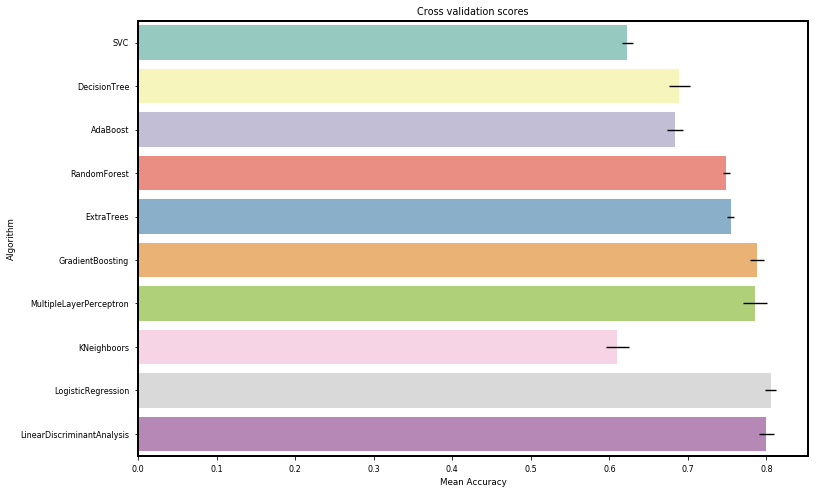

In [38]:
# Modeling step Test differents algorithms 
random_state = 201
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, x_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=16))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [39]:
# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=201)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1],
              "random_state": [201]
            }

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 16, verbose = 1)

gsadaDTC.fit(x_train,y_train)

ada_best = gsadaDTC.best_estimator_

# Best score
gsadaDTC.best_score_

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   12.2s
[Parallel(n_jobs=16)]: Done 320 out of 320 | elapsed:   22.1s finished


0.68804256510781292

In [40]:
ada_pred = ada_best.fit(x_train,y_train)
ada_pred_valid = ada_pred.predict_proba(x_valid)

In [41]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()

## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [2, 3, 4, 5, 6, 7, 8],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [25,50],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"],
              "random_state": [201]
            }


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 16, verbose = 1)

gsExtC.fit(x_train,y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.7s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   11.8s
[Parallel(n_jobs=16)]: Done 420 out of 420 | elapsed:   37.9s finished


0.76743209185102212

In [42]:
extc_pred = ExtC_best.fit(x_train,y_train)
extc_pred_valid = extc_pred.predict_proba(x_valid)

In [43]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [2, 3, 4, 5, 6, 7, 8],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [20,25,50],
              "bootstrap": [False],
              "n_estimators" :[25,250,500],
              "criterion": ["gini"],
              "random_state": [201]
            }


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs=16, verbose = 1)

gsRFC.fit(x_train,y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 5 folds for each of 189 candidates, totalling 945 fits


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    3.2s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   22.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:   57.0s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  2.0min
[Parallel(n_jobs=16)]: Done 945 out of 945 | elapsed:  2.6min finished


0.78549425931111738

In [44]:
rfc_pred = RFC_best.fit(x_train,y_train)
rfc_pred_valid = rfc_pred.predict_proba(x_valid)

In [45]:
# Gradient boosting tunning
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [200,300],
              'learning_rate': [0.1, 0.05],
              'max_depth': [3,4,5,6],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1],
              'random_state': [201]
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 16, verbose = 1)

gsGBC.fit(x_train,y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    9.2s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:  1.5min
[Parallel(n_jobs=16)]: Done 320 out of 320 | elapsed:  2.8min finished


0.82049845981517777

In [46]:
gbc_pred = GBC_best.fit(x_train,y_train)
gbc_pred_valid = gbc_pred.predict_proba(x_valid)

In [47]:
### SVM classifier
SVM = LinearSVC()
svm_param_grid = {
            'penalty':['l2'],
            'C':[0.1,0.5,1.0,1.5,2,10,100],
            'loss':['hinge','squared_hinge'],
            'random_state': [201]
        }

gsSVM = GridSearchCV(SVM,param_grid = svm_param_grid, cv=kfold, scoring="accuracy", n_jobs= 16, verbose = 1)

gsSVM.fit(x_train,y_train)

SVM_best = gsSVM.best_estimator_

# Best score
gsSVM.best_score_

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    4.6s
[Parallel(n_jobs=16)]: Done  70 out of  70 | elapsed:   12.7s finished


0.73606832819938395

In [48]:
svm_pred = SVM_best.fit(x_train,y_train)
svm_pred_valid = svm_pred.predict(x_valid)

In [49]:
### XGBOOST
XGB = XGBClassifier()
xgb_param_grid = {
              'learning_rate': [0.1,0.05,0.01],
              'max_depth': [2,3,4,5,6,7],
              'random_state': [201]
              }

gsXGB = GridSearchCV(XGB,param_grid = xgb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 16, verbose = 1)

gsXGB.fit(x_train,y_train)

XGB_best = gsXGB.best_estimator_

# Best score
gsXGB.best_score_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   20.3s
[Parallel(n_jobs=16)]: Done  90 out of  90 | elapsed:  1.3min finished


0.81167740128815458

In [50]:
xgb_pred = XGB_best.fit(x_train,y_train)
xgb_pred_valid = XGB_best.predict_proba(x_valid)

In [51]:
#LDA
LDA = LinearDiscriminantAnalysis()
lda_param_grid = {
            'n_components':[None], 
            'priors':[None], 
            'shrinkage':[None],
            'solver':['svd'], 
            'store_covariance':[False],
            'tol':[0.0001]
            }

gsLDA = GridSearchCV(LDA,param_grid = lda_param_grid, cv=kfold, scoring="accuracy", n_jobs= 16, verbose = 1)

gsLDA.fit(x_train,y_train)

LDA_best = gsLDA.best_estimator_

# Best score
gsLDA.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=16)]: Done   5 out of   5 | elapsed:    1.7s finished


0.80005600672080646

In [52]:
lda_pred = LDA_best.fit(x_train,y_train)
lda_pred_valid = LDA_best.predict_proba(x_valid)

In [53]:
#NN
NN = MLPClassifier()
nn_param_grid = {
            'max_iter': [1000,2000],
            'activation': ["logistic", "relu"],
            'hidden_layer_sizes': [(20,10,8,5,3), (10,8,5,3), (10,5,3), (5,3)],
            'random_state': [201]
        }

gsNN = GridSearchCV(NN,param_grid = nn_param_grid, cv=kfold, scoring="accuracy", n_jobs= 16, verbose = 1)

gsNN.fit(x_train,y_train)

NN_best = gsNN.best_estimator_

# Best score
gsNN.best_score_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:  1.1min
[Parallel(n_jobs=16)]: Done  80 out of  80 | elapsed:  2.4min finished


0.80719686362363485

In [54]:
nn_pred = NN_best.fit(x_train,y_train)
nn_pred_valid = NN_best.predict_proba(x_valid)

In [55]:
NN_best

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 5, 3), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=201,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

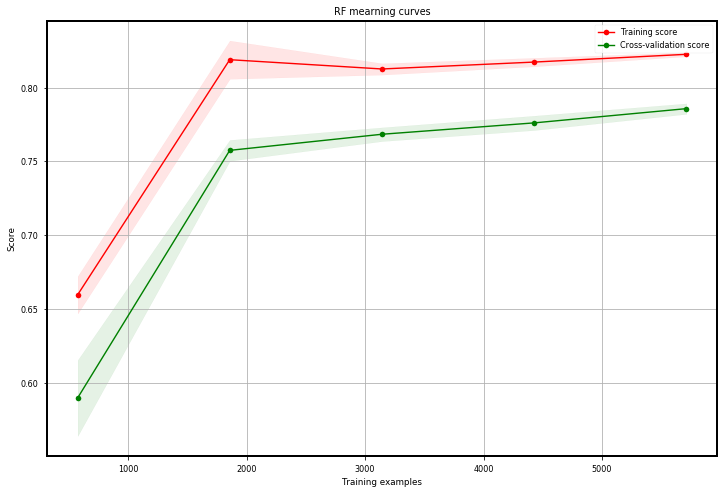

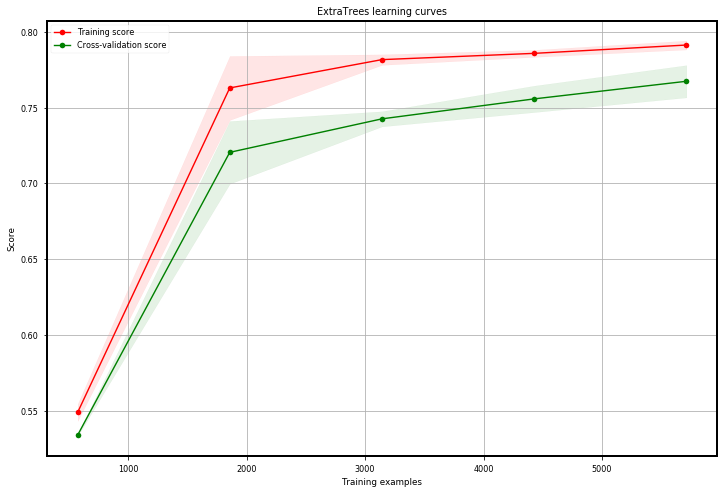

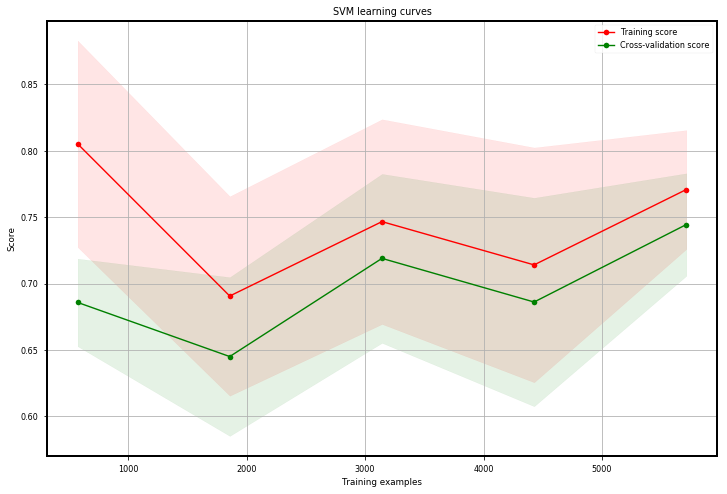

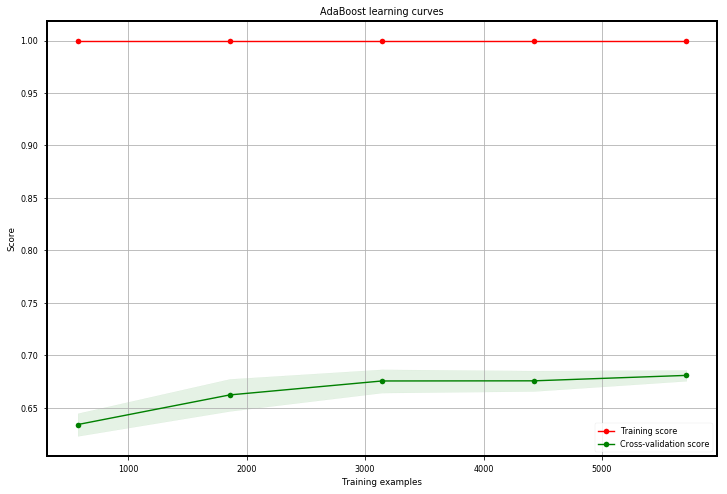

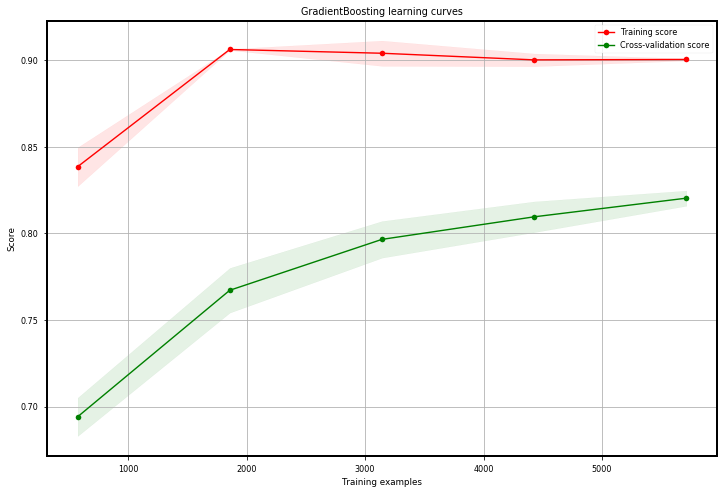

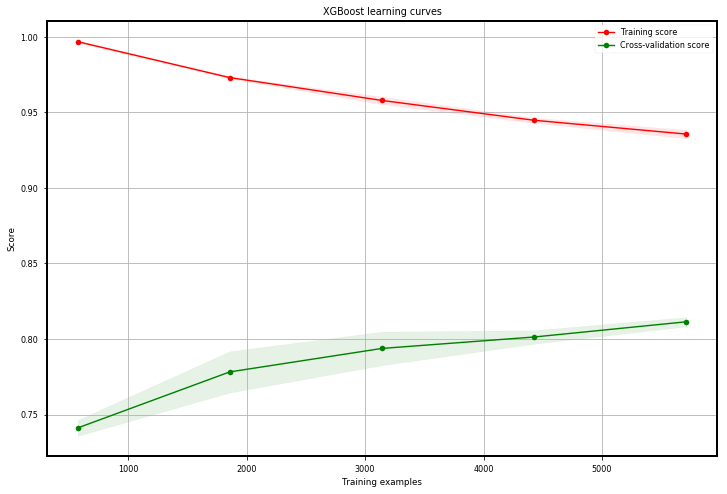

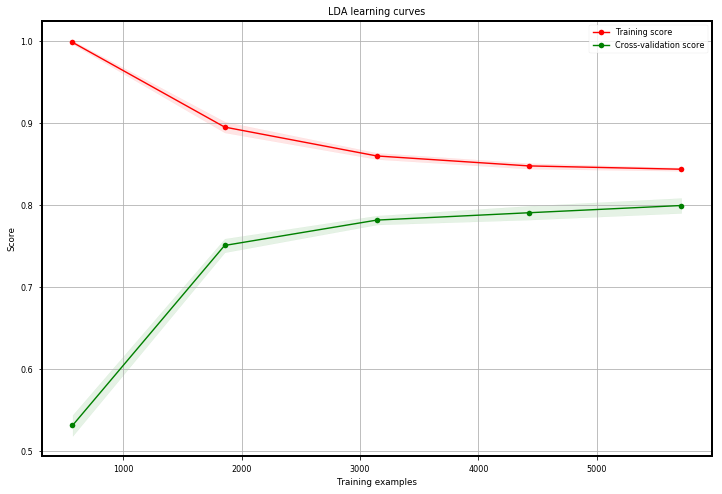

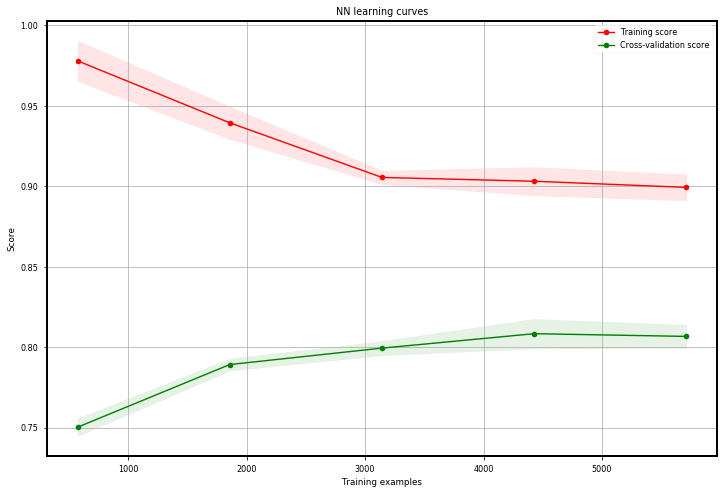

In [56]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",x_train,y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",x_train,y_train,cv=kfold)
g = plot_learning_curve(gsSVM.best_estimator_,"SVM learning curves",x_train,y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",x_train,y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",x_train,y_train,cv=kfold)
g = plot_learning_curve(gsXGB.best_estimator_,"XGBoost learning curves",x_train,y_train,cv=kfold)
g = plot_learning_curve(gsLDA.best_estimator_,"LDA learning curves",x_train,y_train,cv=kfold)
g = plot_learning_curve(gsNN.best_estimator_,"NN learning curves",x_train,y_train,cv=kfold)

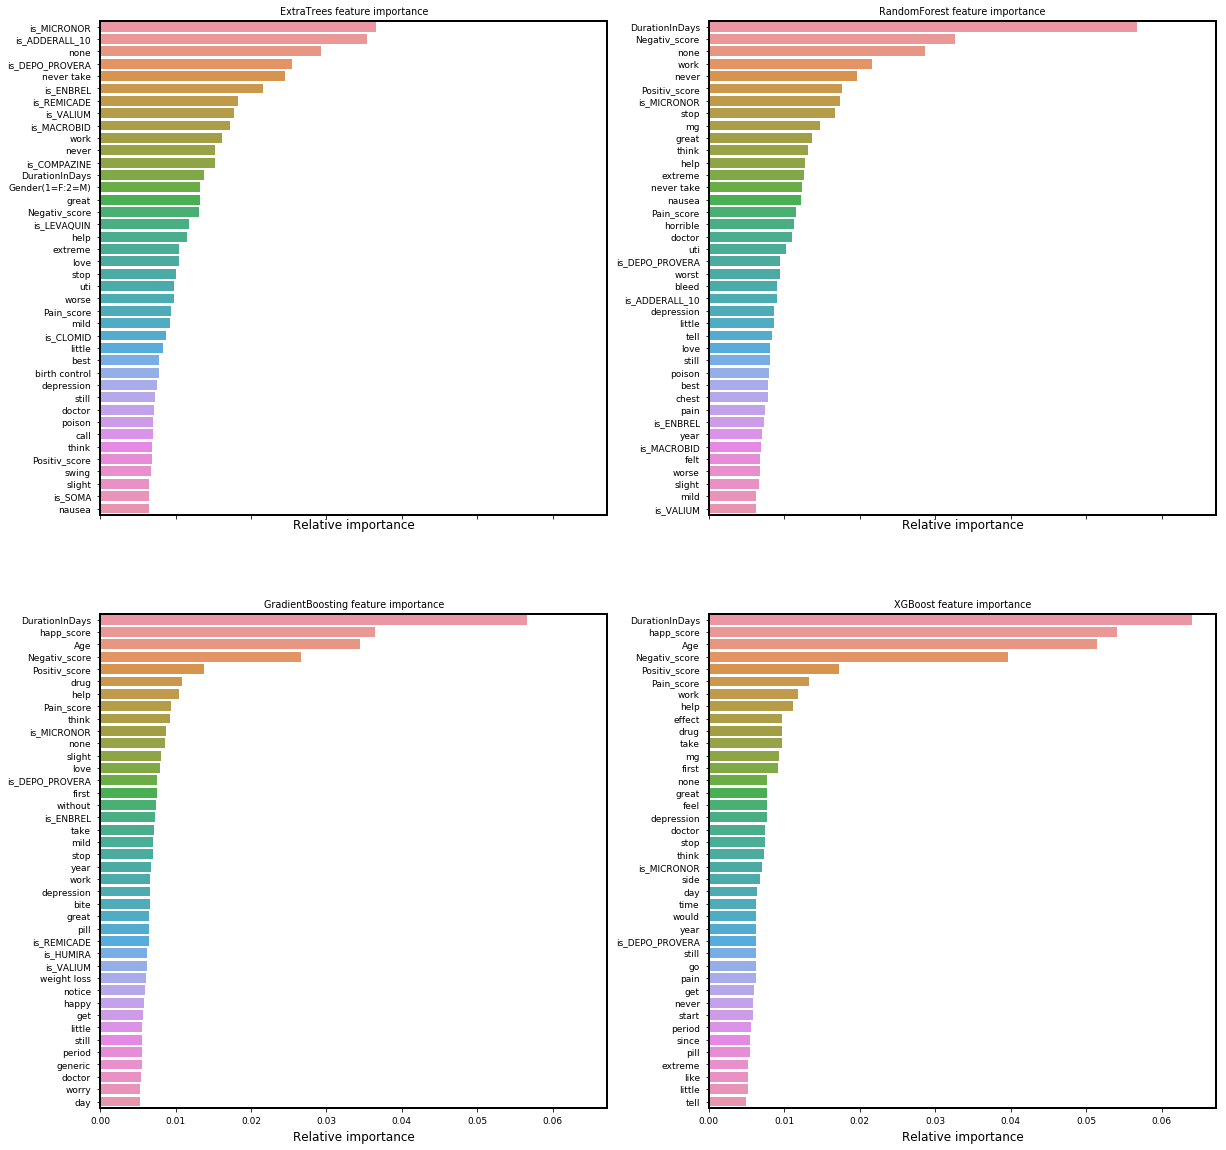

In [57]:
nrows = 2
ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(20,20))

names_classifiers = [("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best),("XGBoost",XGB_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=x_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

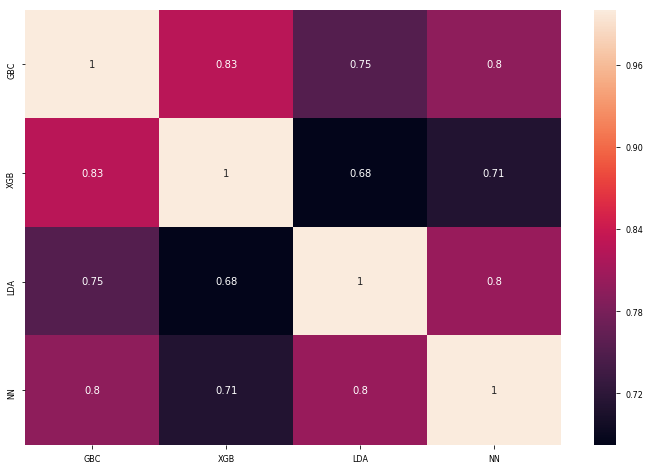

In [58]:
test_Survived_GBC = pd.Series(GBC_best.predict(x_valid), name="GBC")
test_Survived_XGB = pd.Series(XGB_best.predict(x_valid), name="XGB")
test_Survived_LDA = pd.Series(LDA_best.predict(x_valid), name="LDA")
test_Survived_NN = pd.Series(NN_best.predict(x_valid), name="NN")

# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_GBC,test_Survived_XGB,test_Survived_LDA,test_Survived_NN],axis=1)

g=sns.heatmap(ensemble_results.corr(),annot=True)

Ensemble models

In [59]:
# dropped the Ada, because it was poor and underfit
# dropped the extra trees, because it looked overfit
# dropped SVM, because it doesn't have probability capabilities
# dropped RF, because it was not as good at performing as the 3 models included
votingC = VotingClassifier(estimators=[('gbc',GBC_best),('xgb',XGB_best),('lda',LDA_best),('nn',NN_best)], voting='soft', n_jobs=16)
votingC = votingC.fit(x_train,y_train)

prediction_array = votingC.predict_proba(x_valid)
pred_valid = pd.DataFrame(prediction_array)[1]

In [60]:
accuracy_score(y_valid, pred_valid.round())

0.82024359512809741

Create test preditions

In [61]:
ada_pred = ada_best.fit(x_train_orig,y_train_orig)
extc_pred = ExtC_best.fit(x_train_orig,y_train_orig)
rfc_pred = RFC_best.fit(x_train_orig,y_train_orig)
gbc_pred = GBC_best.fit(x_train_orig,y_train_orig)
svm_pred = SVM_best.fit(x_train_orig,y_train_orig)
xgb_pred = XGB_best.fit(x_train_orig,y_train_orig)
lda_pred = LDA_best.fit(x_train_orig,y_train_orig)
nn_pred = NN_best.fit(x_train_orig,y_train_orig)

ada_pred_test = ada_pred.predict_proba(x_test)
extc_pred_test = extc_pred.predict_proba(x_test)
rfc_pred_test = rfc_pred.predict_proba(x_test)
gbc_pred_test = gbc_pred.predict_proba(x_test)
svm_pred_test = svm_pred.predict(x_test)
xgb_pred_test = XGB_best.predict_proba(x_test)
lda_pred_test = LDA_best.predict_proba(x_test)
nn_pred_test = NN_best.predict_proba(x_test)

In [62]:
accuracy_score(y_test, pd.DataFrame(ada_pred_test)[1].round())

0.69201680672268906

In [63]:
accuracy_score(y_test, pd.DataFrame(extc_pred_test)[1].round())

0.76512605042016801

In [64]:
accuracy_score(y_test, pd.DataFrame(rfc_pred_test)[1].round())

0.78151260504201681

In [65]:
accuracy_score(y_test, pd.DataFrame(svm_pred_test))

0.58025210084033618

In [66]:
accuracy_score(y_test, pd.DataFrame(gbc_pred_test)[1].round())

0.8214285714285714

In [67]:
accuracy_score(y_test, pd.DataFrame(xgb_pred_test)[1].round())

0.81554621848739495

In [68]:
accuracy_score(y_test, pd.DataFrame(lda_pred_test)[1].round())

0.81092436974789917

In [69]:
accuracy_score(y_test, pd.DataFrame(nn_pred_test)[1].round())

0.8172268907563025

In [70]:
votingC = VotingClassifier(estimators=[('gbc',GBC_best),('xgb',XGB_best),('lda',LDA_best),('nn',NN_best)], voting='soft', n_jobs=16)
votingC = votingC.fit(x_train_orig,y_train_orig)
prediction_array = votingC.predict_proba(x_test)
pred_test = pd.DataFrame(prediction_array)[1]

In [71]:
accuracy_score(y_test, pred_test.round())

0.83109243697478996

In [72]:
#confusion matrix doesn't handle continuous (predict binary)
ada_pred_test_binary = ada_pred.predict(x_test)
extc_pred_test_binary = extc_pred.predict(x_test)
rfc_pred_test_binary = rfc_pred.predict(x_test)
gbc_pred_test_binary = gbc_pred.predict(x_test)
xgb_pred_test_binary = XGB_best.predict(x_test)
lda_pred_test_binary = LDA_best.predict(x_test)
nn_pred_test_binary = NN_best.predict(x_test)

In [73]:
prediction_array_binary = votingC.predict(x_test)
pred_test_binary = pd.DataFrame(prediction_array_binary)

# ROC and confusion matrix in test set

In [74]:
PLOT_FONT_SIZE = 10    #font size for axis of plots

#define helper function for confusion matrix

def displayConfusionMatrix(confusionMatrix):
    """Confusion matrix plot"""
    
    confusionMatrix = np.transpose(confusionMatrix)
    
    ## calculate class level precision and recall from confusion matrix
    precisionLow = round((confusionMatrix[0][0] / (confusionMatrix[0][0] + confusionMatrix[0][1]))*100, 1)
    precisionHigh = round((confusionMatrix[1][1] / (confusionMatrix[1][0] + confusionMatrix[1][1]))*100, 1)
    recallLow = round((confusionMatrix[0][0] / (confusionMatrix[0][0] + confusionMatrix[1][0]))*100, 1)
    recallHigh = round((confusionMatrix[1][1] / (confusionMatrix[0][1] + confusionMatrix[1][1]))*100, 1)

    ## show heatmap
    plt.imshow(confusionMatrix, interpolation='nearest',cmap=plt.cm.Blues,vmin=0, vmax=100)
    
    ## axis labeling
    xticks = np.array([0,1])
    plt.gca().set_xticks(xticks)
    plt.gca().set_yticks(xticks)
    plt.gca().set_xticklabels(["High Severity \n Recall=" + str(recallLow), "Low Severity \n Recall=" + str(recallHigh)], fontsize=PLOT_FONT_SIZE)
    plt.gca().set_yticklabels(["High Severity \n Precision=" + str(precisionLow), "Low Severity \n Precision=" + str(precisionHigh)], fontsize=PLOT_FONT_SIZE)
    plt.ylabel("Predicted Class", fontsize=PLOT_FONT_SIZE)
    plt.xlabel("Actual Class", fontsize=PLOT_FONT_SIZE)
        
    ## add text in heatmap boxes
    addText(xticks, xticks, confusionMatrix)
    
def addText(xticks, yticks, results):
    """Add text in the plot"""
    for i in range(len(yticks)):
        for j in range(len(xticks)):
            text = plt.text(j, i, results[i][j], ha="center", va="center", color="white", size=PLOT_FONT_SIZE) ### size here is the size of text inside a single box in the heatmap

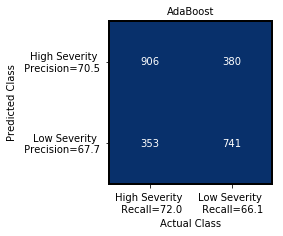

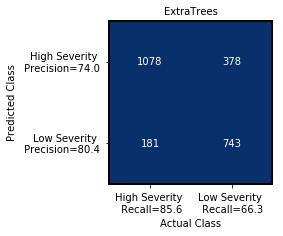

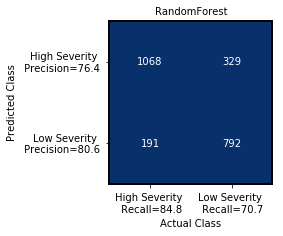

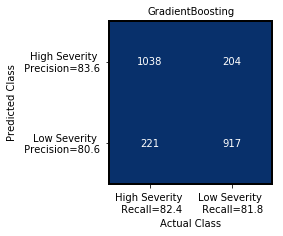

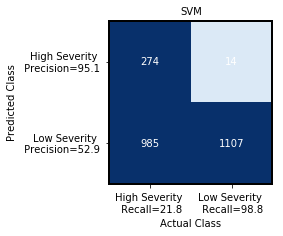

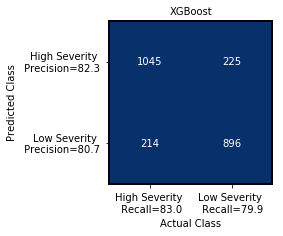

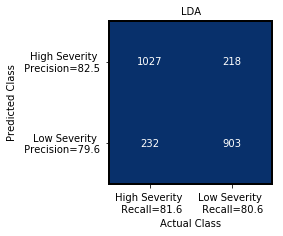

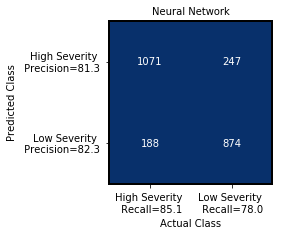

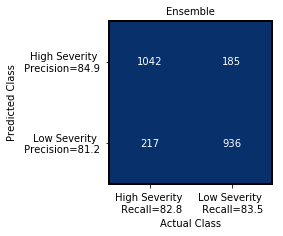

In [75]:
#generate confusion matrices for the different models' training fit
#Ada
confusionMatrix = None
confusionMatrix = confusion_matrix(y_test, ada_pred_test_binary)

## confusion matrix for Ada
plt.rcParams['figure.figsize'] = [3, 3] ## plot size
displayConfusionMatrix(confusionMatrix)
plt.title("AdaBoost", fontsize=PLOT_FONT_SIZE)
plt.show()

#extra trees
confusionMatrix = None
confusionMatrix = confusion_matrix(y_test, extc_pred_test_binary)

# confusion matrix for extra trees
plt.rcParams['figure.figsize'] = [3, 3] ## plot size
displayConfusionMatrix(confusionMatrix)
plt.title("ExtraTrees", fontsize=PLOT_FONT_SIZE)
plt.show()

#RF
confusionMatrix = None
confusionMatrix = confusion_matrix(y_test, rfc_pred_test_binary)

## confusion matrix for RF
plt.rcParams['figure.figsize'] = [3, 3] ## plot size
displayConfusionMatrix(confusionMatrix)
plt.title("RandomForest", fontsize=PLOT_FONT_SIZE)
plt.show()

#GradientBoosting
confusionMatrix = None
confusionMatrix = confusion_matrix(y_test, gbc_pred_test_binary)

## confusion matrix for GradientBoosting
plt.rcParams['figure.figsize'] = [3, 3] ## plot size
displayConfusionMatrix(confusionMatrix)
plt.title("GradientBoosting", fontsize=PLOT_FONT_SIZE)
plt.show()

#SVM
confusionMatrix = None
confusionMatrix = confusion_matrix(y_test, svm_pred_test)

## confusion matrix for SVM
plt.rcParams['figure.figsize'] = [3, 3] ## plot size
displayConfusionMatrix(confusionMatrix)
plt.title("SVM", fontsize=PLOT_FONT_SIZE)
plt.show()

#XGBoost
confusionMatrix = None
confusionMatrix = confusion_matrix(y_test, xgb_pred_test_binary)

## confusion matrix for XGBoost
plt.rcParams['figure.figsize'] = [3, 3] ## plot size
displayConfusionMatrix(confusionMatrix)
plt.title("XGBoost", fontsize=PLOT_FONT_SIZE)
plt.show()

#LDA
confusionMatrix = None
confusionMatrix = confusion_matrix(y_test, lda_pred_test_binary)

## confusion matrix for LDA
plt.rcParams['figure.figsize'] = [3, 3] ## plot size
displayConfusionMatrix(confusionMatrix)
plt.title("LDA", fontsize=PLOT_FONT_SIZE)
plt.show()

#NN
confusionMatrix = None
confusionMatrix = confusion_matrix(y_test, nn_pred_test_binary)

## confusion matrix for NN
plt.rcParams['figure.figsize'] = [3, 3] ## plot size
displayConfusionMatrix(confusionMatrix)
plt.title("Neural Network", fontsize=PLOT_FONT_SIZE)
plt.show()

#Ensemble
confusionMatrix = None
confusionMatrix = confusion_matrix(y_test, pred_test_binary)

## confusion matrix for Ensemble
plt.rcParams['figure.figsize'] = [3, 3] ## plot size
displayConfusionMatrix(confusionMatrix)
plt.title("Ensemble", fontsize=PLOT_FONT_SIZE)
plt.show()

In [76]:
PLOT_FONT_SIZE = 10    #font size for axis of plots
global rocCurveData

## lists for ROC curves
rocCurveData = []
fpr, tpr, threshold = None, None, None

#define helper function for plotting ROC curves

def displaySingleROCCurve(MODEL_NAME, testLabels, predictionsConfidence):
    """ROC Curve plot"""
    predictionsConfidence = [item[1] for item in predictionsConfidence]
    fpr, tpr, threshold = roc_curve(testLabels, predictionsConfidence)
    
    ## plot roc curve
    plt.rcParams['figure.figsize'] = [8, 6]
    plt.plot(fpr,tpr, linewidth=3.0, color='#d60000')
    setLabelsAndTicks("False Positive Rate", "True Positive Rate", None, None, PLOT_FONT_SIZE, rotation=0)
    plt.title("ROC Curve for " + MODEL_NAME,fontsize=PLOT_FONT_SIZE)
    plt.tight_layout()
    plt.show()

def setLabelsAndTicks(xlabel, ylabel, xticks, yticks, fontsize, rotation=0):
    """Set axis and ticks labels in the plot"""
    if xticks == None:
        plt.xlabel(xlabel, fontsize=fontsize)
        plt.ylabel(ylabel,fontsize=fontsize)
        plt.xticks(fontsize=fontsize, rotation=rotation)
        plt.yticks(fontsize=fontsize)
    else:
        x = np.arange(len(xticks))
        plt.xlabel(xlabel, fontsize=fontsize)
        plt.ylabel(ylabel,fontsize=fontsize)
        plt.xticks(x, xticks, fontsize=fontsize, rotation=rotation)
        plt.yticks(x, yticks, fontsize=fontsize)

In [77]:
#generate ROC plot data for all models' training fit
rocCurveData=[]

#ADA
MODEL_NAME = "AdaBoost"
predictionProb = [item[1] for item in ada_pred_test] # we need to only use first column in 2D prob array
fpr, tpr, threshold = roc_curve(y_test, predictionProb)
rocCurveData.append([MODEL_NAME, fpr, tpr])

#ExtraTrees
MODEL_NAME = "ExtraTrees"
predictionProb = [item[1] for item in extc_pred_test] # we need to only use first column in 2D prob array
fpr, tpr, threshold = roc_curve(y_test, predictionProb)
rocCurveData.append([MODEL_NAME, fpr, tpr])

#RandomForest
MODEL_NAME = "Random Forest"
predictionProb = [item[1] for item in rfc_pred_test] # we need to only use first column in 2D prob array
fpr, tpr, threshold = roc_curve(y_test, predictionProb)
rocCurveData.append([MODEL_NAME, fpr, tpr])

#GBC
MODEL_NAME = "Gradient Boosting"
predictionProb = [item[1] for item in gbc_pred_test] # we need to only use first column in 2D prob array
fpr, tpr, threshold = roc_curve(y_test, predictionProb)
rocCurveData.append([MODEL_NAME, fpr, tpr])

#XGB
MODEL_NAME = "XGBoost"
predictionProb = [item[1] for item in xgb_pred_test] # we need to only use first column in 2D prob array
fpr, tpr, threshold = roc_curve(y_test, predictionProb)
rocCurveData.append([MODEL_NAME, fpr, tpr])

#LDA
MODEL_NAME = "LDA"
predictionProb = [item[1] for item in lda_pred_test] # we need to only use first column in 2D prob array
fpr, tpr, threshold = roc_curve(y_test, predictionProb)
rocCurveData.append([MODEL_NAME, fpr, tpr])

#NN
MODEL_NAME = "Neural Network"
predictionProb = [item[1] for item in nn_pred_test] # we need to only use first column in 2D prob array
fpr, tpr, threshold = roc_curve(y_test, predictionProb)
rocCurveData.append([MODEL_NAME, fpr, tpr])

#Ensemble
MODEL_NAME = "Ensemble"
predictionProb = [item[1] for item in prediction_array] # we need to only use first column in 2D prob array
fpr, tpr, threshold = roc_curve(y_test, predictionProb)
rocCurveData.append([MODEL_NAME, fpr, tpr])

+++ Plotting ROC curves for different models


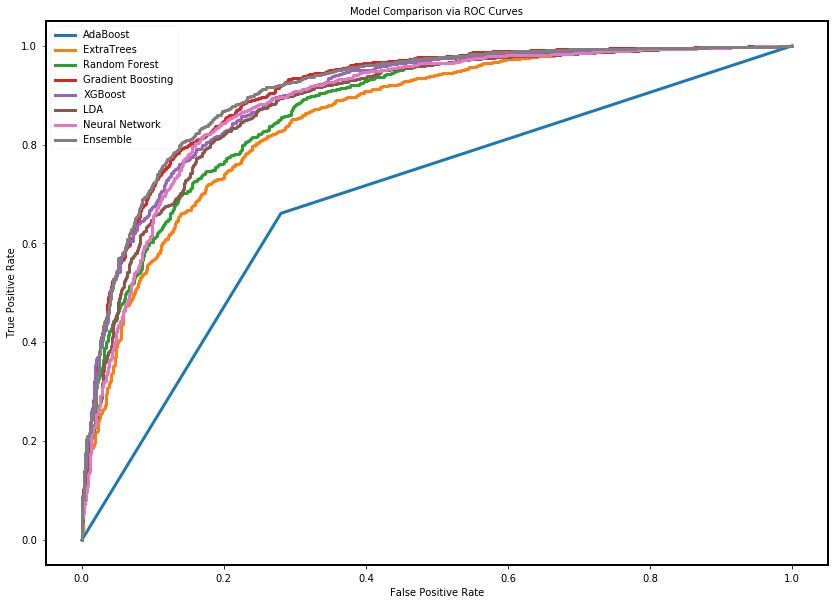

In [78]:
## Plot ROC curves for all models.
plt.rcParams['figure.figsize'] = [14, 10]
print('+++ Plotting ROC curves for different models')
classificationSettings = [item[0] for item in rocCurveData]
fprs = [item[1] for item in rocCurveData]
tprs = [item[2] for item in rocCurveData]

for c in range(0, len(classificationSettings)):
    plt.plot(fprs[c],tprs[c], linewidth=3.0)

plt.title("Model Comparison via ROC Curves",fontsize=PLOT_FONT_SIZE)
plt.legend(classificationSettings, fontsize=PLOT_FONT_SIZE)
plt.xticks(fontsize=PLOT_FONT_SIZE)
plt.yticks(fontsize=PLOT_FONT_SIZE)
plt.xlabel("False Positive Rate",fontsize=PLOT_FONT_SIZE)
plt.ylabel("True Positive Rate",fontsize=PLOT_FONT_SIZE)
plt.show()